In [1]:
#Importing Libraries

import numpy as np
import matplotlib.pyplot as plt
import os
import PIL
from PIL import Image
import datetime
import os

In [2]:
#Setting Seeds for shuffling files in csv

np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In [3]:
#Downloading files for google drive

import gdown

# Replace 'your_google_drive_link_here' with the actual Google Drive link of the dataset
data_url = 'https://drive.google.com/uc?id=1ehyrYBQ5rbQQe6yL4XbLWe3FMvuVUGiL'
file_name = data_url.split('/')[-1]  # Extracting the file name from the URL

# Download the data from the Google Drive link
gdown.download(data_url, file_name, quiet=False)

# Unzip the downloaded dataset
!unzip {file_name}

# Remove the zip file after extraction
!rm {file_name}

Downloading...
From: https://drive.google.com/uc?id=1ehyrYBQ5rbQQe6yL4XbLWe3FMvuVUGiL
To: /content/uc?id=1ehyrYBQ5rbQQe6yL4XbLWe3FMvuVUGiL
100%|██████████| 1.71G/1.71G [00:11<00:00, 144MB/s]


Streaming output truncated to the last 5000 lines.
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00050.png  
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00052.png  
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00054.png  
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00056.png  
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00058.png  
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00060.png  
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00062.png  
   creating: Project_data/train/WIN_20180926_17_35_12_Pro_Thumbs_Down_new/
 extracting: Project_data/train/WIN_20180926_17_35_12_Pro_Thumbs_Down_new/WIN_20180926_17_35_12_Pro_00001.png  
 extracting: Project_data/t

In [4]:
#Reading csv files for data generator

train_doc = np.random.permutation(open('/content/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/content/Project_data/val.csv').readlines())
batch_size = 32

In [5]:
#Defining Data Generator

def generator(source_path, folder_list, batch_size,x,y,z):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [0,1,2,4,6,8,10,12,14,16,18,20,22,24,26,27,28,29]
    while True:
        t = np.random.permutation(folder_list)
        num_batches = int(len(t)/batch_size)                                   # calculate the number of batches
        for batch in range(num_batches):                                       # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3))                        # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5))                            # batch_labels is the one hot representation of the output
            for folder in range(batch_size):                                   # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0])                       # read all the images in the folder
                for idx,item in enumerate(img_idx):                                                                    #  Iterate iver the frames/images of a folder to read them in
                    img_path = os.path.join(source_path, t[folder + (batch * batch_size)].strip().split(';')[0], imgs[item])
                    image = Image.open(img_path)
                    if image.size[0] == 160:
                        image = image.crop((20,0,140,120))
                    image = image.resize(size = (y,z))
                    image = np.asarray(image).astype(np.float32)

                    #crop the images and resize them. Note that the images are of 2 different shape
                    #and the conv3D will throw error if the inputs in a batch have different shapes

                    batch_data[folder,idx,:,:,0] = image[:,:,0]/255           #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = image[:,:,1]/255           #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image[:,:,2]/255           #normalise and feed in the image

                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do


        # write the code for the remaining data points which are left after full batches

        if (len(t) % batch_size) != 0:
            batch_data = np.zeros((len(t)%batch_size,x,y,z,3))
            batch_labels = np.zeros((len(t)%batch_size,5))
            for folder in range(len(t)%batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    image = Image.open(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item])
                    if image.size[0] == 160:
                        image = image.crop((20,0,140,120))                    # left =20, top =0, right = 140, bottom = 120

                    image = image.resize(size = (y,z))
                    image = np.asarray(image).astype(np.float32)


                    batch_data[folder,idx,:,:,0] = image[:,:,0]/255           #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = image[:,:,1]/255           #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image[:,:,2]/255           #normalise and feed in the image

                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels


In [6]:
curr_dt_time = datetime.datetime.now()
train_path = '/content/Project_data/train'
val_path = '/content/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 32       # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 32


In [7]:
#Mandatory Imports

from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation,Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

In [8]:
#Defining 3D convolutional Neural Network

def Conv3d(x,y,z):
  conv3d = Sequential()
  conv3d.add(Conv3D(64, (3,3,3), strides=(1,1,1), padding='same', input_shape=(x,y,z,3)))
  conv3d.add(BatchNormalization())
  conv3d.add(Activation('relu'))
  conv3d.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

  conv3d.add(Conv3D(128, (3,3,3), strides=(1,1,1), padding='same'))
  conv3d.add(BatchNormalization())
  conv3d.add(Activation('relu'))
  conv3d.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))


  conv3d.add(Conv3D(256, (3,3,3), strides=(1,1,1), padding='same'))
  conv3d.add(BatchNormalization())
  conv3d.add(Activation('relu'))
  conv3d.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))


  conv3d.add(Conv3D(256, (3,3,3), strides=(1,1,1), padding='same'))
  conv3d.add(BatchNormalization())
  conv3d.add(Activation('relu'))
  conv3d.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

  conv3d.add(Flatten())
  conv3d.add(Dropout(0.5))
  conv3d.add(Dense(512, activation='relu'))
  conv3d.add(Dropout(0.5))
  conv3d.add(Dense(5, activation='softmax'))
  return conv3d

In [9]:
#Defining optimizers for convolutional Neural Network and checking parameters

optimiser = optimizers.SGD(learning_rate=0.001, decay=1e-6, momentum=0.7, nesterov=True)          #write your optimizer
img_idx = [0,1,2,4,6,8,10,12,14,16,18,20,22,24,26,27,28,29]
x=len(img_idx)
y=100
z=100
model = Conv3d(x,100,100)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 18, 100, 100, 64)  5248      
                                                                 
 batch_normalization (BatchN  (None, 18, 100, 100, 64)  256      
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 18, 100, 100, 64)  0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 9, 50, 50, 64)    0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 9, 50, 50, 128)    221312    
                                                                 
 batch_normalization_1 (Batc  (None, 9, 50, 50, 128)   5

In [13]:
#Generating data from train folders

batch_size = 32
train_generator = generator(train_path, train_doc, batch_size,x,y,z)
val_generator = generator(val_path, val_doc, batch_size,x,y,z)

In [14]:
#Saving model weights, defining checkpoints and code for reducing LR based on validation loss

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', min_delta=0.0001, cooldown=0, min_lr=0.00001)                       # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [15]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=10, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

<ipython-input-15-972b481edaea>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=10, verbose=1,


Epoch 1/10
21/21 [==============================] - ETA: 0s - loss: 0.9858 - categorical_accuracy: 0.6109
Epoch 1: saving model to model_init_2023-07-3104_13_25.770530/model-00001-0.98578-0.61086-4.21577-0.18000.h5
21/21 [==============================] - 46s 2s/step - loss: 0.9858 - categorical_accuracy: 0.6109 - val_loss: 4.2158 - val_categorical_accuracy: 0.1800 - lr: 6.2500e-05
Epoch 2/10
21/21 [==============================] - ETA: 0s - loss: 0.9418 - categorical_accuracy: 0.6124
Epoch 2: saving model to model_init_2023-07-3104_13_25.770530/model-00002-0.94181-0.61237-4.23535-0.16000.h5
21/21 [==============================] - 44s 2s/step - loss: 0.9418 - categorical_accuracy: 0.6124 - val_loss: 4.2353 - val_categorical_accuracy: 0.1600 - lr: 6.2500e-05
Epoch 3/10
21/21 [==============================] - ETA: 0s - loss: 0.9687 - categorical_accuracy: 0.6259
Epoch 3: saving model to model_init_2023-07-3104_13_25.770530/model-00003-0.96865-0.62594-4.25227-0.16000.h5

Epoch 3: Reduc

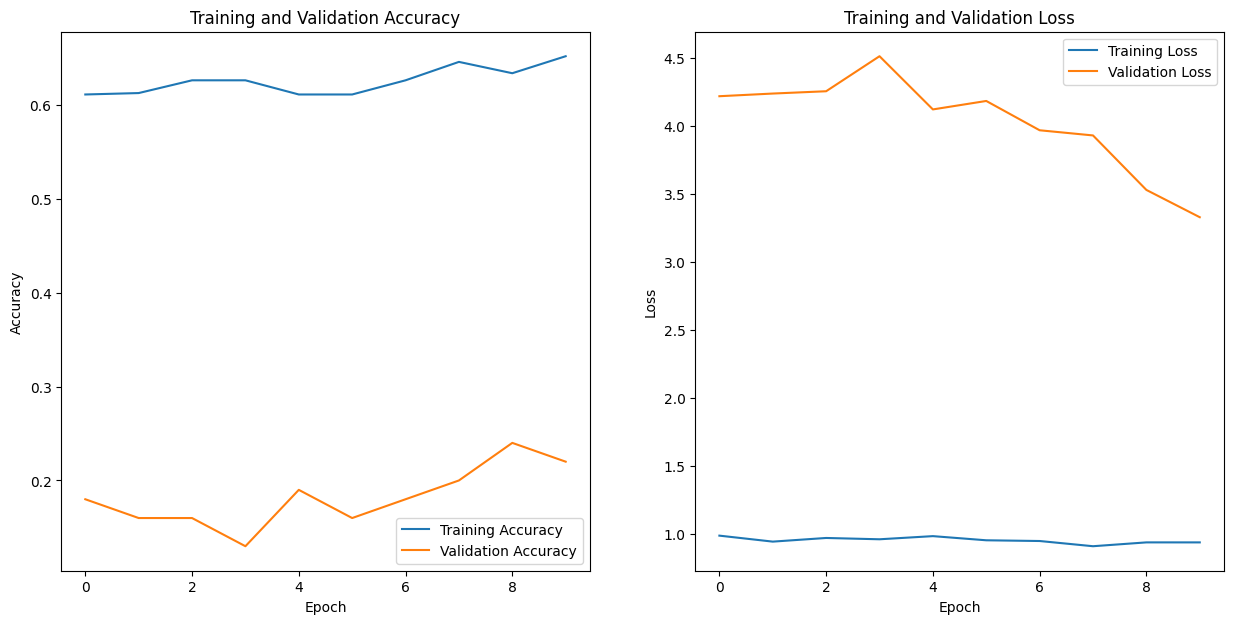

In [ ]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.plot( acc, label='Training Accuracy')
plt.plot( val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot( loss, label='Training Loss')
plt.plot( val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

As can be seen from graphs above, model is overfitting and validation accuracy isnt increasing. May be model is unable to learn from features extracted from CNN layers. Hence, we add more dense layer and observe the result.

In [ ]:
img_idx = [0,1,2,4,6,8,10,12,14,16,18,20,22,24,26,27,28,29]
x=len(img_idx)


model = Sequential()
model.add(Conv3D(64, (3,3,3), strides=(1,1,1), padding='same', input_shape=(x,100,100,3)))
#model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

model.add(Conv3D(128, (3,3,3), strides=(1,1,1), padding='same'))
#model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))


model.add(Conv3D(256, (3,3,3), strides=(1,1,1), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

model.add(Flatten())
#model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dense(512,activation='relu'))
model.add(Dense(5, activation='softmax'))


In [ ]:
optimiser = optimizers.SGD(learning_rate=0.001, decay=1e-6, momentum=0.7, nesterov=True)          #write your optimizer

model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_7 (Conv3D)           (None, 18, 100, 100, 64)  5248      
                                                                 
 activation_7 (Activation)   (None, 18, 100, 100, 64)  0         
                                                                 
 max_pooling3d_7 (MaxPooling  (None, 9, 50, 50, 64)    0         
 3D)                                                             
                                                                 
 conv3d_8 (Conv3D)           (None, 9, 50, 50, 128)    221312    
                                                                 
 activation_8 (Activation)   (None, 9, 50, 50, 128)    0         
                                                                 
 max_pooling3d_8 (MaxPooling  (None, 4, 25, 25, 128)   0         
 3D)                                                  

In [ ]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=32, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

<ipython-input-21-3040c7e17e38>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=32, verbose=1,


Source path =  /content/Project_data/train ; batch size = 32
Epoch 1/32
21/21 [==============================] - ETA: 0s - loss: 1.6410 - categorical_accuracy: 0.3394Source path =  /content/Project_data/val ; batch size = 32

Epoch 1: saving model to model_init_2023-08-0109_24_30.203777/model-00001-1.64105-0.33937-1.58692-0.32000.h5
21/21 [==============================] - 63s 2s/step - loss: 1.6410 - categorical_accuracy: 0.3394 - val_loss: 1.5869 - val_categorical_accuracy: 0.3200 - lr: 0.0010
Epoch 2/32
21/21 [==============================] - ETA: 0s - loss: 1.1418 - categorical_accuracy: 0.5249
Epoch 2: saving model to model_init_2023-08-0109_24_30.203777/model-00002-1.14176-0.52489-1.58219-0.19000.h5
21/21 [==============================] - 48s 2s/step - loss: 1.1418 - categorical_accuracy: 0.5249 - val_loss: 1.5822 - val_categorical_accuracy: 0.1900 - lr: 0.0010
Epoch 3/32
21/21 [==============================] - ETA: 0s - loss: 0.8739 - categorical_accuracy: 0.6757
Epoch 3: sav

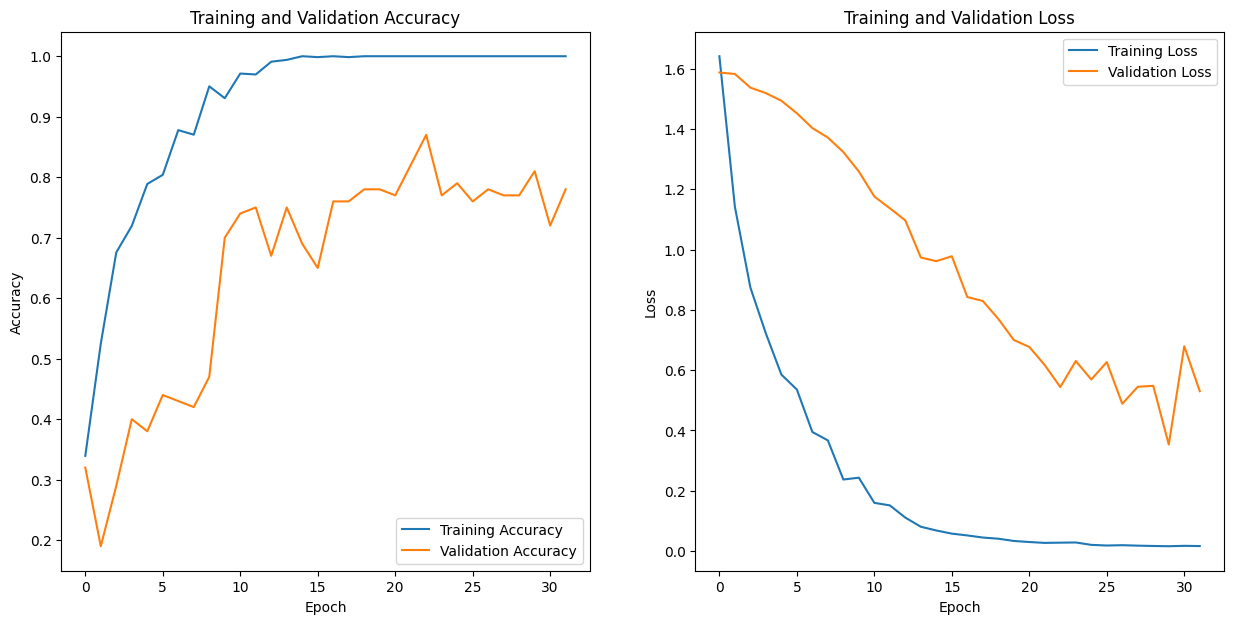

In [ ]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.plot( acc, label='Training Accuracy')
plt.plot( val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot( loss, label='Training Loss')
plt.plot( val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

Model still is overfitting. Hence we try some variations in 3D convolution only.

In [ ]:
final_model = Sequential()
final_model.add(Conv3D(64, (3,3,3), strides=(1,1,1), padding='same', input_shape=(x,100,100,3)))
#model.add(BatchNormalization())
final_model.add(Activation('relu'))
final_model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

final_model.add(Conv3D(128, (3,3,3), strides=(1,1,1), padding='same'))
#model.add(BatchNormalization())
final_model.add(Activation('relu'))
final_model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))


final_model.add(Conv3D(256, (3,3,3), strides=(1,1,1), padding='same'))
final_model.add(BatchNormalization())
final_model.add(Activation('relu'))
final_model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

final_model.add(Flatten())
#model.add(Dropout(0.5))
final_model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
final_model.add(Dense(512,activation='relu'))
final_model.add(Dense(5, activation='softmax'))

In [ ]:

from tensorflow.keras.regularizers import l2

final_model = Sequential()

final_model.add(Conv3D(64, (3, 3, 3), strides=(1, 1, 1), padding='same', input_shape=(x, 100, 100, 3),
                       kernel_regularizer=l2(0.01)))
final_model.add(Activation('relu'))
final_model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2)))

final_model.add(Conv3D(128, (3, 3, 3), strides=(1, 1, 1), padding='same'))
final_model.add(Activation('relu'))
final_model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2)))

final_model.add(Conv3D(256, (3, 3, 3), strides=(1, 1, 1), padding='same'))
final_model.add(BatchNormalization())
final_model.add(Activation('relu'))
final_model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2)))

final_model.add(Flatten())
final_model.add(Dense(512, activation='relu'))
final_model.add(Dropout(0.5))
final_model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.01)))
final_model.add(Dense(5, activation='softmax'))


In [ ]:
optimiser = optimizers.SGD(learning_rate=0.001, decay=1e-6, momentum=0.7, nesterov=True)          #write your optimizer

final_model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (final_model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_7 (Conv3D)           (None, 18, 100, 100, 64)  5248      
                                                                 
 activation_7 (Activation)   (None, 18, 100, 100, 64)  0         
                                                                 
 max_pooling3d_7 (MaxPooling  (None, 9, 50, 50, 64)    0         
 3D)                                                             
                                                                 
 conv3d_8 (Conv3D)           (None, 9, 50, 50, 128)    221312    
                                                                 
 activation_8 (Activation)   (None, 9, 50, 50, 128)    0         
                                                                 
 max_pooling3d_8 (MaxPooling  (None, 4, 25, 25, 128)   0         
 3D)                                                  

In [ ]:
history = final_model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=21, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

<ipython-input-22-69cdd7f93581>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = final_model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=21, verbose=1,


Epoch 1/21
21/21 [==============================] - ETA: 0s - loss: 6.9938 - categorical_accuracy: 0.2760
Epoch 1: saving model to model_init_2023-07-3105_32_41.527134/model-00001-6.99383-0.27602-6.77959-0.18000.h5
21/21 [==============================] - 50s 2s/step - loss: 6.9938 - categorical_accuracy: 0.2760 - val_loss: 6.7796 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 2/21
21/21 [==============================] - ETA: 0s - loss: 6.4758 - categorical_accuracy: 0.4374
Epoch 2: saving model to model_init_2023-07-3105_32_41.527134/model-00002-6.47582-0.43741-6.73892-0.41000.h5
21/21 [==============================] - 52s 3s/step - loss: 6.4758 - categorical_accuracy: 0.4374 - val_loss: 6.7389 - val_categorical_accuracy: 0.4100 - lr: 0.0010
Epoch 3/21
21/21 [==============================] - ETA: 0s - loss: 6.3345 - categorical_accuracy: 0.5008
Epoch 3: saving model to model_init_2023-07-3105_32_41.527134/model-00003-6.33451-0.50075-6.72025-0.24000.h5
21/21 [================

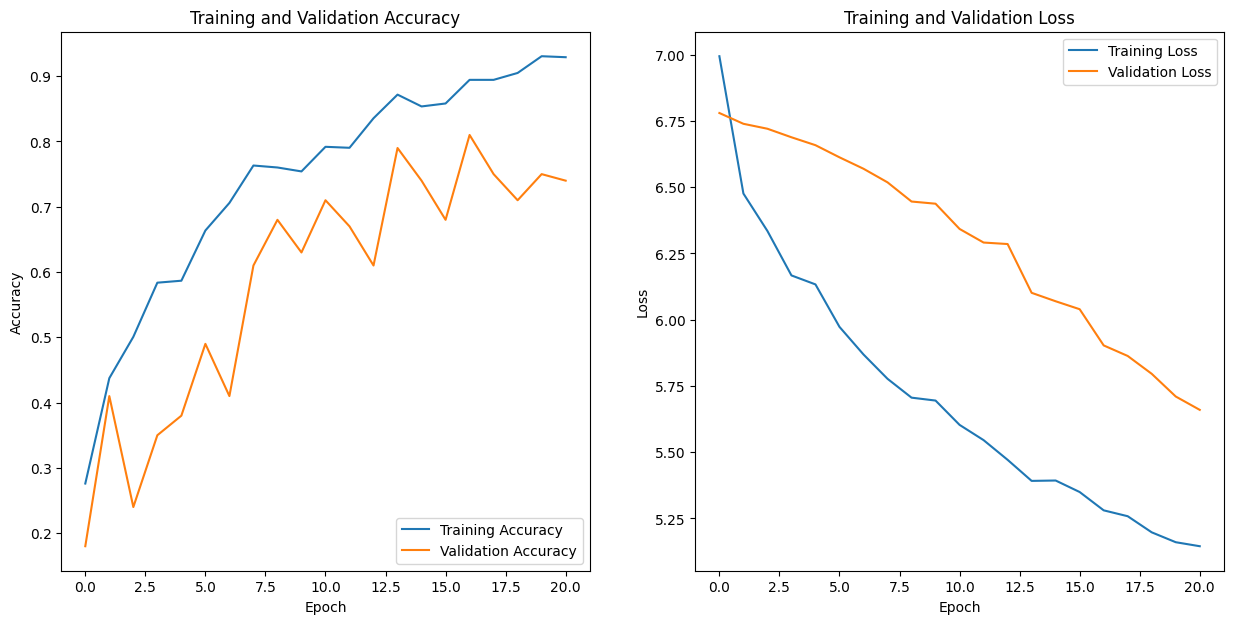

In [ ]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.plot( acc, label='Training Accuracy')
plt.plot( val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot( loss, label='Training Loss')
plt.plot( val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

Regularizers worked better but the model is still overfitting. Hence, need more dropout layers to stop overfitting.

In [ ]:
final_model = Sequential()
final_model.add(Conv3D(64, (3,3,3), strides=(1,1,1), padding='same', input_shape=(x,100,100,3)))
model.add(BatchNormalization())
final_model.add(Activation('relu'))
final_model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

final_model.add(Conv3D(128, (3,3,3), strides=(1,1,1), padding='same'))
model.add(BatchNormalization())
final_model.add(Activation('relu'))
final_model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))


final_model.add(Conv3D(256, (3,3,3), strides=(1,1,1), padding='same'))
final_model.add(BatchNormalization())
final_model.add(Activation('relu'))
final_model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

final_model.add(Flatten())
#model.add(Dropout(0.5))
final_model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
final_model.add(Dense(256,activation='relu'))
model.add(Dropout(0.5))
final_model.add(Dense(64,activation='relu'))
final_model.add(Dense(5, activation='softmax'))

In [ ]:
optimiser = optimizers.SGD(learning_rate=0.001, decay=1e-6, momentum=0.7, nesterov=True)          #write your optimizer

final_model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (final_model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_13 (Conv3D)          (None, 18, 100, 100, 64)  5248      
                                                                 
 activation_13 (Activation)  (None, 18, 100, 100, 64)  0         
                                                                 
 max_pooling3d_13 (MaxPoolin  (None, 9, 50, 50, 64)    0         
 g3D)                                                            
                                                                 
 conv3d_14 (Conv3D)          (None, 9, 50, 50, 128)    221312    
                                                                 
 activation_14 (Activation)  (None, 9, 50, 50, 128)    0         
                                                                 
 max_pooling3d_14 (MaxPoolin  (None, 4, 25, 25, 128)   0         
 g3D)                                                 

In [ ]:
history = final_model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=21, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

<ipython-input-27-69cdd7f93581>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = final_model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=21, verbose=1,


Epoch 1/21
21/21 [==============================] - ETA: 0s - loss: 1.5124 - categorical_accuracy: 0.3273
Epoch 1: saving model to model_init_2023-07-3105_32_41.527134/model-00001-1.51243-0.32730-1.59240-0.27000.h5
21/21 [==============================] - 50s 2s/step - loss: 1.5124 - categorical_accuracy: 0.3273 - val_loss: 1.5924 - val_categorical_accuracy: 0.2700 - lr: 0.0010
Epoch 2/21
21/21 [==============================] - ETA: 0s - loss: 1.1606 - categorical_accuracy: 0.5158
Epoch 2: saving model to model_init_2023-07-3105_32_41.527134/model-00002-1.16059-0.51584-1.58233-0.24000.h5
21/21 [==============================] - 51s 3s/step - loss: 1.1606 - categorical_accuracy: 0.5158 - val_loss: 1.5823 - val_categorical_accuracy: 0.2400 - lr: 0.0010
Epoch 3/21
21/21 [==============================] - ETA: 0s - loss: 0.9666 - categorical_accuracy: 0.5897
Epoch 3: saving model to model_init_2023-07-3105_32_41.527134/model-00003-0.96655-0.58974-1.55923-0.26000.h5
21/21 [================

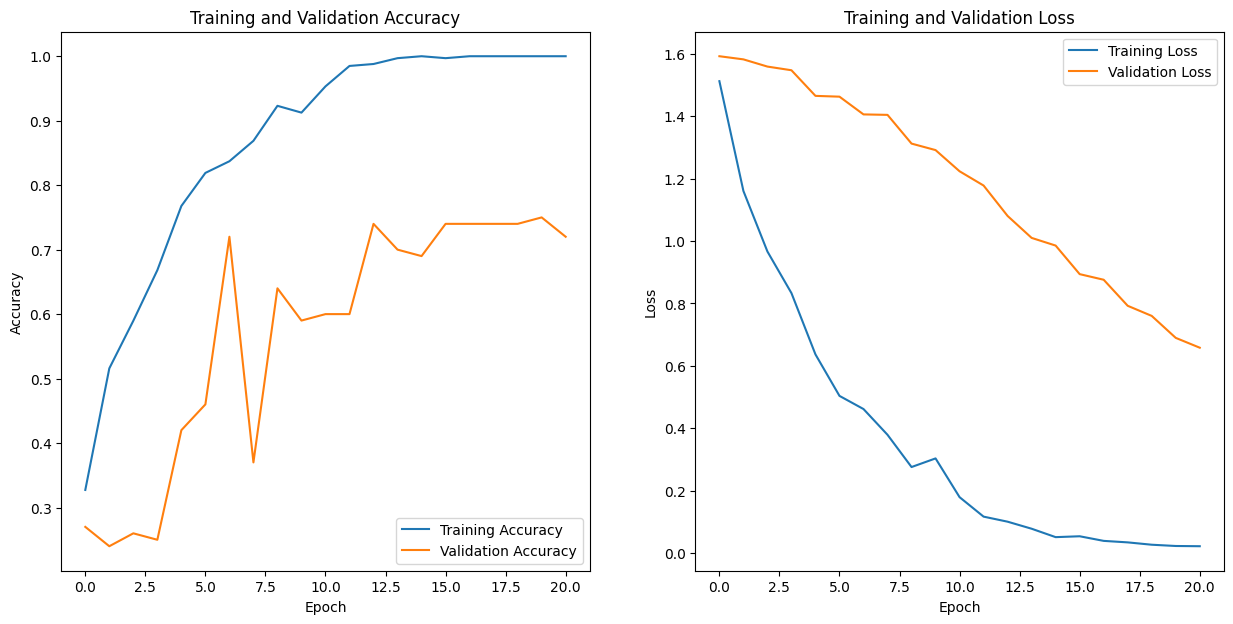

In [ ]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.plot( acc, label='Training Accuracy')
plt.plot( val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot( loss, label='Training Loss')
plt.plot( val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In this case model named "model_init_2023-07-3105_32_41.527134/model-00017-0.03922-1.00000-0.87607-0.74000.h5" seems to give highest validation accuracy of 87%. Hence, we download the weights and try CNN+RNN stacked models

In [ ]:
final_model = Sequential()
final_model.add(Conv3D(64, (3,3,3), strides=(1,1,1), padding='same', input_shape=(x,100,100,3)))
model.add(BatchNormalization())
final_model.add(Activation('relu'))
final_model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

final_model.add(Conv3D(128, (3,3,3), strides=(1,1,1), padding='same'))
model.add(BatchNormalization())
final_model.add(Activation('relu'))
final_model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))


final_model.add(Conv3D(256, (3,3,3), strides=(1,1,1), padding='same'))
final_model.add(BatchNormalization())
final_model.add(Activation('relu'))
final_model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

final_model.add(Flatten())
model.add(Dropout(0.5))
final_model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
final_model.add(Dense(256,activation='relu'))
model.add(Dropout(0.5))
final_model.add(Dense(64,activation='relu'))
final_model.add(Dense(5, activation='softmax'))


In [ ]:
optimiser = optimizers.SGD(learning_rate=0.001, decay=1e-6, momentum=0.7, nesterov=True)          #write your optimizer

final_model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (final_model.summary())

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_21 (Conv3D)          (None, 18, 100, 100, 64)  5248      
                                                                 
 activation_21 (Activation)  (None, 18, 100, 100, 64)  0         
                                                                 
 max_pooling3d_21 (MaxPoolin  (None, 9, 50, 50, 64)    0         
 g3D)                                                            
                                                                 
 conv3d_22 (Conv3D)          (None, 9, 50, 50, 128)    221312    
                                                                 
 activation_22 (Activation)  (None, 9, 50, 50, 128)    0         
                                                                 
 max_pooling3d_22 (MaxPoolin  (None, 4, 25, 25, 128)   0         
 g3D)                                                 

In [ ]:
history = final_model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=32, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

<ipython-input-36-30d6aaca3ad4>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = final_model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=32, verbose=1,


Epoch 1/32
21/21 [==============================] - ETA: 0s - loss: 0.0288 - categorical_accuracy: 1.0000
Epoch 1: saving model to model_init_2023-07-3105_32_41.527134/model-00001-0.02877-1.00000-0.67123-0.77000.h5
21/21 [==============================] - 49s 2s/step - loss: 0.0288 - categorical_accuracy: 1.0000 - val_loss: 0.6712 - val_categorical_accuracy: 0.7700 - lr: 0.0010
Epoch 2/32
21/21 [==============================] - ETA: 0s - loss: 0.0277 - categorical_accuracy: 1.0000
Epoch 2: saving model to model_init_2023-07-3105_32_41.527134/model-00002-0.02770-1.00000-0.62841-0.78000.h5
21/21 [==============================] - 49s 2s/step - loss: 0.0277 - categorical_accuracy: 1.0000 - val_loss: 0.6284 - val_categorical_accuracy: 0.7800 - lr: 0.0010
Epoch 3/32
21/21 [==============================] - ETA: 0s - loss: 0.0253 - categorical_accuracy: 1.0000
Epoch 3: saving model to model_init_2023-07-3105_32_41.527134/model-00003-0.02526-1.00000-0.70982-0.75000.h5
21/21 [================

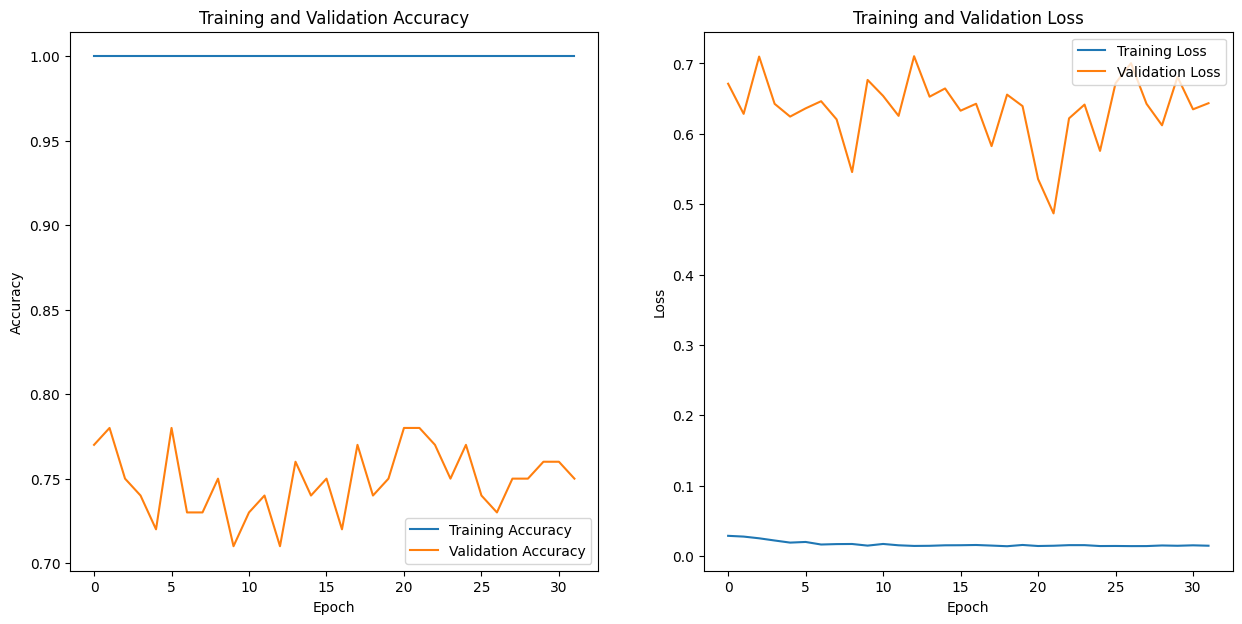

In [ ]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.plot( acc, label='Training Accuracy')
plt.plot( val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot( loss, label='Training Loss')
plt.plot( val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

### CNN + LSTM Stack for gesture Recognition

In [ ]:
from keras.applications.vgg16 import VGG16
from keras.applications import mobilenet
from keras.layers import Dense, LSTM, GRU



img_idx = [0,1,2,4,6,8,10,12,14,16,18,20,22,24,26,27,28,29]
x=len(img_idx)

base_model = VGG16(include_top=False, weights='imagenet', input_shape=(100,100,3))
a = base_model.output
a = Flatten()(a)
features = Dense(64, activation='relu')(a)
conv_model = Model(inputs=base_model.input, outputs=features)

for layer in base_model.layers:
  layer.trainable = False

model = Sequential()
model.add(TimeDistributed(conv_model, input_shape=(x,100,100,3)))

model.add(LSTM(64, return_sequences=True))
model.add(LSTM(32))

model.add(Dense(8, activation='relu'))

model.add(Dense(5, activation='softmax'))

58889256/58889256 [==============================] - 2s 0us/step


In [ ]:
sgd = optimizers.SGD(learning_rate=0.001, decay=1e-6, momentum=0.7, nesterov=True)

model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 18, 64)           15009664  
 ibuted)                                                         
                                                                 
 lstm (LSTM)                 (None, 18, 64)            33024     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dense_9 (Dense)             (None, 8)                 264       
                                                                 
 dense_10 (Dense)            (None, 5)                 45        
                                                                 
Total params: 15,055,413
Trainable params: 340,725
Non-trainable params: 14,714,688
____________________________________

In [ ]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=32, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

<ipython-input-25-3040c7e17e38>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=32, verbose=1,


Epoch 1/32
21/21 [==============================] - ETA: 0s - loss: 1.6213 - categorical_accuracy: 0.1900
Epoch 1: saving model to model_init_2023-08-0109_24_30.203777/model-00001-1.62127-0.19005-1.60524-0.23000.h5
21/21 [==============================] - 81s 3s/step - loss: 1.6213 - categorical_accuracy: 0.1900 - val_loss: 1.6052 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/32
21/21 [==============================] - ETA: 0s - loss: 1.6056 - categorical_accuracy: 0.2172
Epoch 2: saving model to model_init_2023-08-0109_24_30.203777/model-00002-1.60556-0.21719-1.60812-0.25000.h5
21/21 [==============================] - 47s 2s/step - loss: 1.6056 - categorical_accuracy: 0.2172 - val_loss: 1.6081 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 3/32
21/21 [==============================] - ETA: 0s - loss: 1.5933 - categorical_accuracy: 0.2821
Epoch 3: saving model to model_init_2023-08-0109_24_30.203777/model-00003-1.59330-0.28205-1.58893-0.25000.h5
21/21 [================

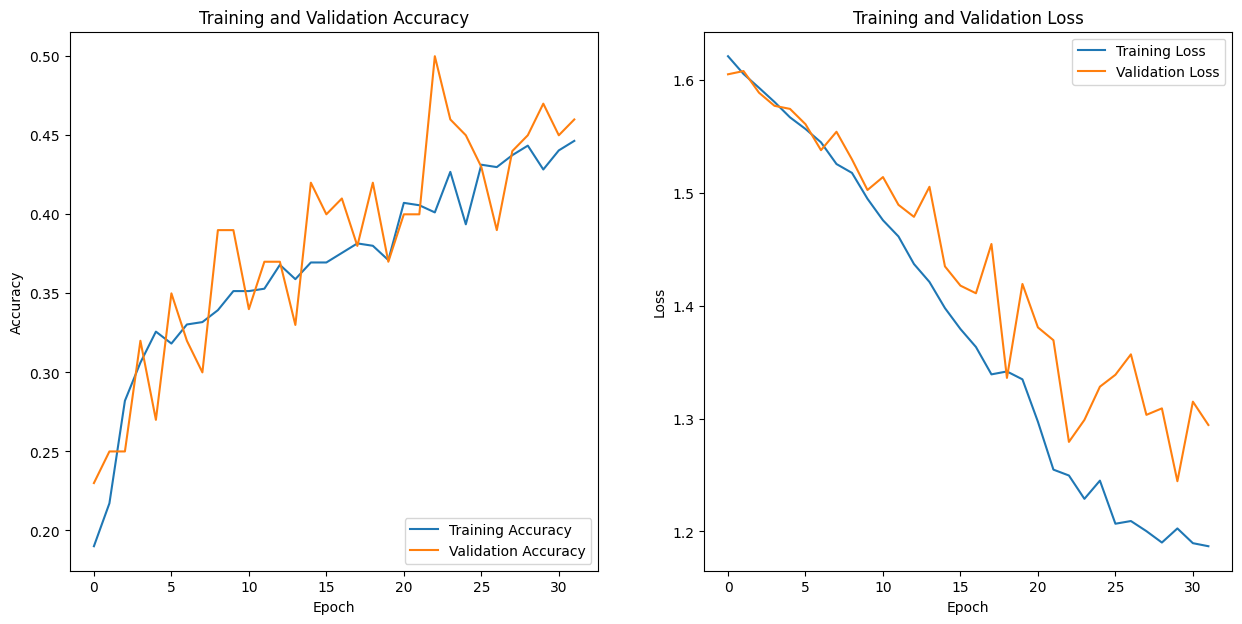

In [ ]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.plot( acc, label='Training Accuracy')
plt.plot( val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot( loss, label='Training Loss')
plt.plot( val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

### Overfitting reduced accuracy is less but appreciable.

In [ ]:
  base_model = VGG16(include_top=False, weights='imagenet', input_shape=(100,100,3))
  a = base_model.output
  a = Flatten()(a)
  features = Dense(64, activation='relu')(a)
  conv_model = Model(inputs=base_model.input, outputs=features)

  for layer in base_model.layers:
      layer.trainable = False

  model = Sequential()
  model.add(TimeDistributed(conv_model, input_shape=(x,y,z,3)))
  model.add(GRU(128, return_sequences=True))
  model.add(GRU(64))
  model.add(Dropout(0.25))
  model.add(Dense(64, activation='relu'))
  model.add(Dense(5, activation='softmax'))

In [ ]:
sgd = optimizers.SGD(learning_rate=0.001, decay=1e-6, momentum=0.7, nesterov=True)

model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_4 (TimeDis  (None, 18, 64)           15009664  
 tributed)                                                       
                                                                 
 gru (GRU)                   (None, 18, 128)           74496     
                                                                 
 gru_1 (GRU)                 (None, 64)                37248     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_14 (Dense)            (None, 64)                4160      
                                                                 
 dense_15 (Dense)            (None, 5)                 325       
                                                      

In [ ]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=32, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

<ipython-input-42-3040c7e17e38>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=32, verbose=1,


Epoch 1/32
21/21 [==============================] - ETA: 0s - loss: 1.6212 - categorical_accuracy: 0.2006
Epoch 1: saving model to model_init_2023-07-3108_47_28.533409/model-00001-1.62123-0.20060-1.61064-0.14000.h5
21/21 [==============================] - 51s 2s/step - loss: 1.6212 - categorical_accuracy: 0.2006 - val_loss: 1.6106 - val_categorical_accuracy: 0.1400 - lr: 0.0010
Epoch 2/32
21/21 [==============================] - ETA: 0s - loss: 1.6021 - categorical_accuracy: 0.2081
Epoch 2: saving model to model_init_2023-07-3108_47_28.533409/model-00002-1.60213-0.20814-1.60494-0.24000.h5
21/21 [==============================] - 47s 2s/step - loss: 1.6021 - categorical_accuracy: 0.2081 - val_loss: 1.6049 - val_categorical_accuracy: 0.2400 - lr: 0.0010
Epoch 3/32
21/21 [==============================] - ETA: 0s - loss: 1.5930 - categorical_accuracy: 0.2308
Epoch 3: saving model to model_init_2023-07-3108_47_28.533409/model-00003-1.59301-0.23077-1.57344-0.33000.h5
21/21 [================

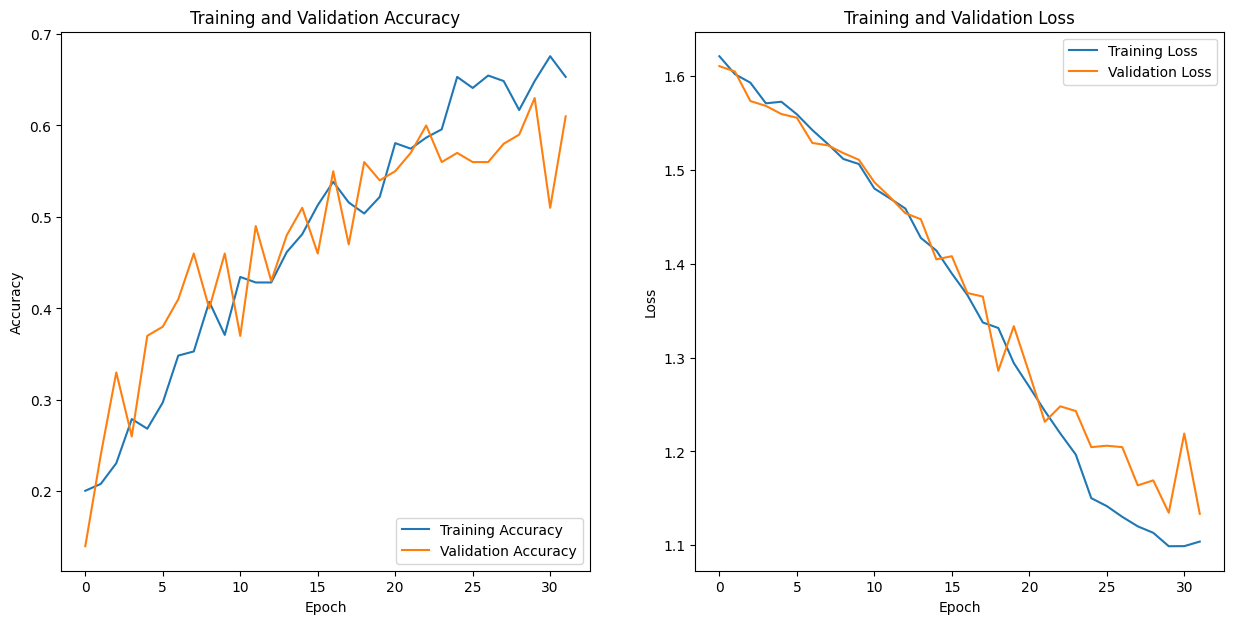

In [ ]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.plot( acc, label='Training Accuracy')
plt.plot( val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot( loss, label='Training Loss')
plt.plot( val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

### CNN+GRU model isn't performing well Hence we go ahead with 3D convolutional Neural Network.

### Second Experiment gave the best results. Hence, we train the model and attach the weights.

In [10]:
img_idx = [0,1,2,4,6,8,10,12,14,16,18,20,22,24,26,27,28,29]
x=len(img_idx)


model = Sequential()
model.add(Conv3D(64, (3,3,3), strides=(1,1,1), padding='same', input_shape=(x,100,100,3)))
#model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

model.add(Conv3D(128, (3,3,3), strides=(1,1,1), padding='same'))
#model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))


model.add(Conv3D(256, (3,3,3), strides=(1,1,1), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

model.add(Flatten())
#model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dense(512,activation='relu'))
model.add(Dense(5, activation='softmax'))

In [11]:
sgd = optimizers.SGD(learning_rate=0.001, decay=1e-6, momentum=0.7, nesterov=True)

model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 18, 100, 100, 64)  5248      
                                                                 
 activation_4 (Activation)   (None, 18, 100, 100, 64)  0         
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 9, 50, 50, 64)    0         
 3D)                                                             
                                                                 
 conv3d_5 (Conv3D)           (None, 9, 50, 50, 128)    221312    
                                                                 
 activation_5 (Activation)   (None, 9, 50, 50, 128)    0         
                                                                 
 max_pooling3d_5 (MaxPooling  (None, 4, 25, 25, 128)   0         
 3D)                                                  

In [16]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=32, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

<ipython-input-16-3040c7e17e38>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=32, verbose=1,


Source path =  /content/Project_data/train ; batch size = 32
Epoch 1/32
21/21 [==============================] - ETA: 0s - loss: 1.7422 - categorical_accuracy: 0.3122Source path =  /content/Project_data/val ; batch size = 32

Epoch 1: saving model to model_init_2023-08-0807_53_05.787771/model-00001-1.74217-0.31222-1.58762-0.23000.h5
21/21 [==============================] - 62s 2s/step - loss: 1.7422 - categorical_accuracy: 0.3122 - val_loss: 1.5876 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/32
21/21 [==============================] - ETA: 0s - loss: 1.1418 - categorical_accuracy: 0.5430
Epoch 2: saving model to model_init_2023-08-0807_53_05.787771/model-00002-1.14175-0.54299-1.58165-0.22000.h5
21/21 [==============================] - 47s 2s/step - loss: 1.1418 - categorical_accuracy: 0.5430 - val_loss: 1.5816 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 3/32
21/21 [==============================] - ETA: 0s - loss: 0.9069 - categorical_accuracy: 0.6546
Epoch 3: sav

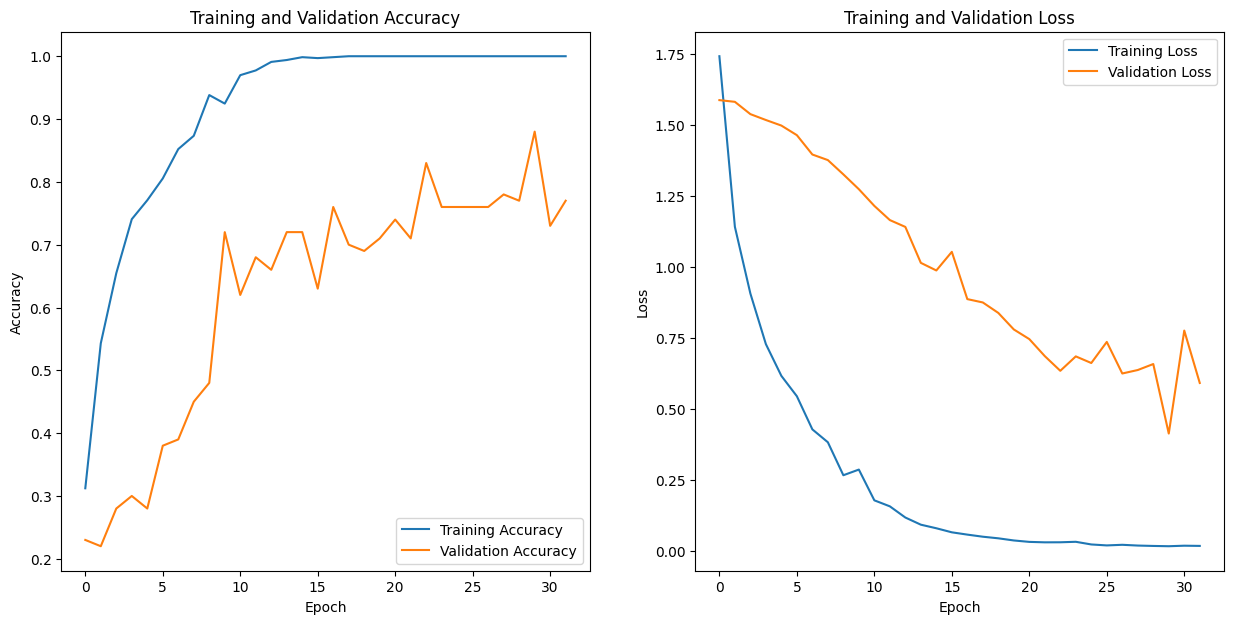

In [17]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.plot( acc, label='Training Accuracy')
plt.plot( val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot( loss, label='Training Loss')
plt.plot( val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

Weights of 30th epoch are downloaded and link of the weights are given in word file. As the model gave validation accuracy is 0.88.  